Goal: Compare prescaled 13144 to 13549 

For ease: use the pkl files included rather than running 13144 and 13549 themselves. 

In [1]:
from iifunctions import *
from adcbinfunctions import *

from lsst.daf.butler import Butler
import numpy as np 
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.signal import savgol_filter

import random 

## 13144 prescaled

In [22]:
def getimages(): 
    hundredimages = "/home/r/rejnicho/analysis/adc/datasets/histdatasetclean.pkl" #687 images 
    with open(hundredimages, "rb") as f:
        ds = pkl.load(f)
    return ds 

def setprescale(): #get this ready because you will later write a better method for doing this
    bounds = [26.5, 26.825, 26.9, 27, 27.25, 27.8, 28.15, 28.5, 28.85, 29.5, 30.2, 30.4, 30.85, 31.2, 31.5, 33.2, 33.5, 
              34.8, 35.9, 38, 40, 42, 44, 50, 50.5, 140] #in e3 units
    dynpre = [1/200, 1/100, 1/80, 1/56, 1/36, 1/18, 1/14, 1/10, 1/8, 1/7, 5/29, 5/27, 1/5, 5/23, 1/4, 5/23, 1/3, 5/13, 
              5/11, 1/2, 5/8, 5/7, 25/32, 1/2, 1]
    return bounds, dynpre

def selectimages(ds, bounds, dynpre):
    fullcounts = np.zeros(140000- 26500-1)
    allbins = np.arange(26500, 140000)
    for x in range(len(ds["C01"])):
        imcounts = ds["C01"][x][0]
        inbins = ds["C01"][x][1]
        nbins = inbins[:-1] 
        #determine the location of the peak of the image 
        maxcounts = max(imcounts)
        locmax = np.argwhere(imcounts == maxcounts)
        if inbins[locmax[0][0]] > 120e3: #cut out stuff above 130k 
            continue 
        #conver locmax into e3 units by /1000, determine the prescale amount 
        res = list(filter(lambda i: i > inbins[locmax[0][0]]/1000, bounds))[0] #in e3 config given how I have this written 
        index = bounds.index(res) -1
        prescale = dynpre[index] 
        #recover the distribution
        adulonglist = np.concatenate([[inbins[i]]*imcounts[i] for i in range(len(imcounts))])
        #now select only the number of elements desired from the prescale (but force it to be an integer amount) 
        randomlyselectedadu = random.sample(list(adulonglist), int(len(adulonglist)*prescale))
        #sort using the generic histogram 
        counts, bins = np.histogram(randomlyselectedadu, bins=allbins)
        #add the counts to the overall 
        fullcounts += counts
    return fullcounts, allbins 

def checkbins(pcounts, pbins): ### this function is wrong in adcbinfunctions.py; you need to correct it at some point 
    issueindex = []
    for x in range(len(pbins)-1):
        if pbins[x] != pbins[x-1] +1:
            issueindex.append(x)            
    if len(issueindex) != 0: #take the last index in the list and begin the lists there
        lastindex = issueindex[1]
        bins = pbins[:lastindex]
        counts = pcounts[:lastindex]  
    else: 
        counts = pcounts
        bins = pbins 
    return counts, bins, lastindex

def getfilter(cts, bns): 
    smoothed = savgol_filter(cts, 33, 3, mode='constant', cval=0) #use the padding
    positive = smoothed > 0 
    
    positivesmoothed = smoothed[positive]
    positivebins = bns[positive]
    filtered, filtbins, lastindex = checkbins(positivesmoothed, positivebins) #check that the filter increasing
    
    validcounts = cts[:lastindex] #match length array to that of the filter 
    
    cumulativesum = np.cumsum(filtered)
    cs = scipy.interpolate.CubicSpline(filtbins +1, cumulativesum) #have right edge
    return cs, filtered, filtbins, validcounts 

def trim(bins, counts): #require min amount of counts to be included 
    abins = bins[:-1] 
    counts150 = counts > 150
    cts = counts[counts150]
    bns = abins[counts150]
    return cts, bns 

In [23]:
ds = getimages()
bounds, dynpre = setprescale()
fullcounts, allbins = selectimages(ds, bounds, dynpre)

In [24]:
cts, bns = trim(allbins, fullcounts) 
cs, filtered, filtbins, validcounts = getfilter(cts, bns) 
e13144, r13144 = makeedges(validcounts, filtbins, cs, 1, 26718, filtbins[-1], False)
w13144 = np.array(e13144[1:]) - np.array(e13144[:-1])

In [5]:
## Create a pkl file where you have the hist, filt, bins, and spline so you can make edges whereever desired 

dict13144 = {}
dict13144["hist"] = validcounts 
dict13144["bins"] = filtbins
dict13144["filter"] = filtered
dict13144["spline"] = cs 

with open("13144_imageinfo.pkl", "wb") as f:
    pkl.dump(dict13144, f)


In [5]:
## Create a pkl file st from earliest bin to contain edges and widths 

d13144 = {} 
d13144['widths'] = w13144
d13144['edges'] = e13144

with open('d13144.pkl', 'wb') as f:
    pkl.dump(d13144, f)

this can still be greatly improved; need to do another effort at it


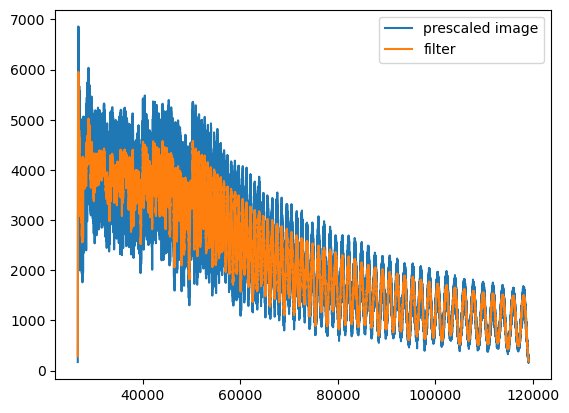

In [26]:
## show distribution 

plt.plot(filtbins, validcounts, label='prescaled image') 
plt.plot(filtbins, filtered, label='filter')
plt.legend()

print("this can still be greatly improved; need to do another effort at it")

## 13549 

In [2]:
! eups list -s lsst_distrib

   g4213664e8e+da93b84f60 	current w_2023_37 setup


In [3]:
def setButler(): 
    repo_path = "/repo/ir2"
    butler = Butler(repo_path, collections=['LSSTCam/photodiode','LSSTCam/raw/all'], instrument='LSSTCam')
    registry = butler.registry

    base_where = "instrument='LSSTCam'"
    recordClasses = butler.registry.queryDimensionRecords('detector', where=base_where)
    det_raft_pairs = sorted([(rc.id, rc.full_name) for rc in recordClasses])

    where = "exposure.science_program='13549' and exposure.observation_type ='ramp'"
    collections = 'LSSTCam/raw/all'
    dataId = {'detector': 90}
    datarefs = list(butler.registry.queryDatasets(datasetType='raw', collections=collections, where=where, dataId=dataId))

    exp = butler.get(datarefs[0]) #use just the first image : ) 
    det = exp.getDetector()

    amps_list = ["C00", "C01", "C02","C03","C04","C05","C06", "C07", "C10","C11","C12", "C13", "C14", "C15", "C16", "C17"]
    ampNames = [amp.getName() for amp in det if amp.getName() in amps_list] #the order in which the channels are in the dataset 
    
    return datarefs, amps_list, ampNames, butler

def definecountsbins(datarefs, amps_list, ampNames, butler): #write a function that iterates over all the images 
    bins = np.arange(2.5e4, 1.25e5)
    counts = np.zeros(125000-25001) 
    for dataref in datarefs:
        exp = butler.get(dataref) 
        det = exp.getDetector()
        trimmed_ims = [exp.getMaskedImage()[amp.getRawDataBBox()].getImage() for amp in det if amp.getName() in amps_list]
        im_arrs = [trimmed_im.getArray().flatten().astype(int) for trimmed_im in trimmed_ims]
        amps_imarrs = {ampName: im_arrs for ampName, im_arrs in zip(ampNames, im_arrs)}
        arrcounts, arrbins = np.histogram(amps_imarrs["C01"], bins=bins)
        counts += arrcounts
    return counts, bins

def trim(bins, counts): #require min amount of counts to be included 
    abins = bins[:-1] 
    counts150 = counts > 150
    cts = counts[counts150]
    bns = abins[counts150]
    return cts, bns 

def checkbins(pcounts, pbins):     ### this function is wrong in adcbinfunctions.py; you need to correct it at some point 
    issueindex = []
    for x in range(len(pbins)-1):
        if pbins[x] != pbins[x-1] +1:
            issueindex.append(x)            
    if len(issueindex) != 0: #take the last index in the list and begin the lists there
        lastindex = issueindex[1]
        bins = pbins[:lastindex]
        counts = pcounts[:lastindex]  
    else: 
        counts = pcounts
        bins = pbins 
    return counts, bins, lastindex

def getfilter(cts, bns): 
    smoothed = savgol_filter(cts, 33, 3, mode='constant', cval=0) #use the padding
    positive = smoothed > 0 
    
    positivesmoothed = smoothed[positive]
    positivebins = bns[positive]
    filtered, filtbins, lastindex = checkbins(positivesmoothed, positivebins) #check that the filter increasing
    
    validcounts = cts[:lastindex] #match length array to that of the filter 
    
    cumulativesum = np.cumsum(filtered)
    cs = scipy.interpolate.CubicSpline(filtbins +1, cumulativesum) #have right edge
    return cs, filtered, filtbins, validcounts 


In [4]:
#takes approx. 3 minutes to run 

datarefs, amps_list, ampNames, butler = setButler()
counts, bins = definecountsbins(datarefs, amps_list, ampNames, butler)
cts, bns = trim(bins, counts)
cs, filtered, filtbins, validcounts = getfilter(cts, bns) 

In [5]:
## Create a pkl file where you have the hist, filt, bins, and spline so you can make edges whereever desired 

dict13549 = {}
dict13549["hist"] = validcounts 
dict13549["bins"] = filtbins
dict13549["filter"] = filtered
dict13549["spline"] = cs 

with open("13549_imageinfo.pkl", "wb") as f:
    pkl.dump(dict13549, f)

In [11]:
## Create a pkl file st from earliest bin to contain edges and widths 

e13549, r13549 = makeedges(validcounts, filtbins, cs, 1, 26690, 1e5, False)
w13549 = np.array(e13549[1:]) - np.array(e13549[:-1])

d13549 = {} 
d13549['widths'] = w13549
d13549['edges'] = e13549

with open('d13549.pkl', 'wb') as f:
    pkl.dump(d13549, f)

(0.0, 5000.0)

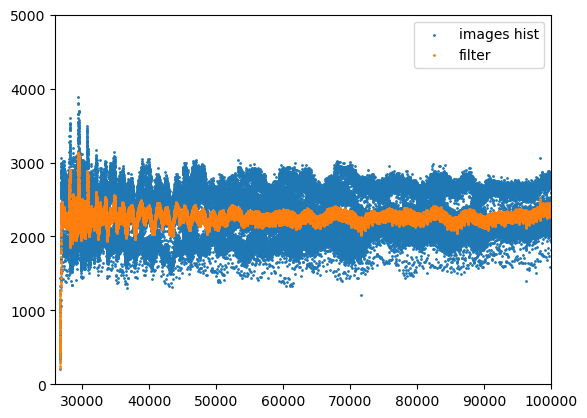

In [17]:
# show distribution 

plt.scatter(filtbins, validcounts, s=1, label='images hist')
plt.scatter(filtbins, filtered, s=1, label='filter')
plt.legend()
plt.xlim(2.6e4, 1e5)
plt.ylim(0, 5e3)

## Compare the two runs; starting from the earliest bins, and then trimming dataset

In [2]:
with open('d13549.pkl', 'rb') as f:
    d13549 = pkl.load(f) #st at 26690
    
with open('d13144.pkl', 'rb') as f:
    d13144 = pkl.load(f) #st at 26718

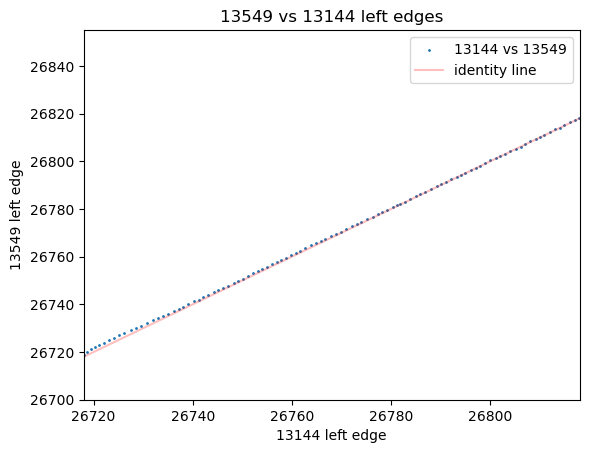

Text(0.5, 1.0, '13549 vs 13144 left edges')

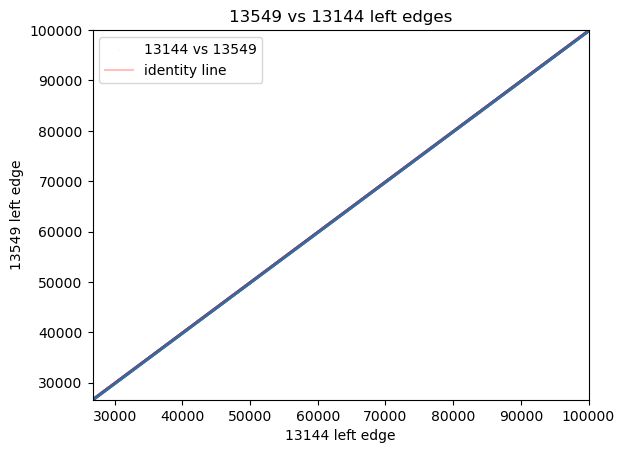

In [3]:
#plot x as 13144, y as 13549 (need to trim so it begins correctly 

e13144 = d13144["edges"]
e13549 = d13549["edges"]

se13549 = copy.deepcopy(e13549) 
se13549 = se13549[28:]

se13144 = copy.deepcopy(e13144)
se13144 = se13144[:73283]

plt.scatter(se13144, se13549, s=1, label="13144 vs 13549")
plt.plot(np.arange(26718, 26718+73283), np.arange(26718, 26718+73283), label='identity line', alpha=0.25, color='red')
plt.legend()
plt.xlim(26718, 26718+100)
plt.ylim(2.67e4, 2.6855e4)
plt.xlabel("13144 left edge")
plt.ylabel("13549 left edge")
plt.title("13549 vs 13144 left edges")
plt.show()

plt.scatter(se13144, se13549, s=0.001, label="13144 vs 13549")
plt.plot(np.arange(26718, 26718+73283), np.arange(26718, 26718+73283), label='identity line', alpha=0.25, color='red')
plt.legend()
plt.xlabel("13144 left edge")
plt.xlim(26718, 26718+73283)
plt.ylim(2.66e4, 10e4)
plt.ylabel("13549 left edge")
plt.title("13549 vs 13144 left edges")

When I plot the left edges against each other (for a trimmed data st at earliest bin which differ) I found that 13549 edges are further along than 13144 for the earliest region of the adc; which is to be expected as 13144 starts at that spot and 13549 it starts even earlier. This is something I seek to fix tho to be able to better compare the two. So I will start binning where dnl is not wild for 13144 and then match it in 13549. See next section where this is put into practice.

(-1.0, 0.5)

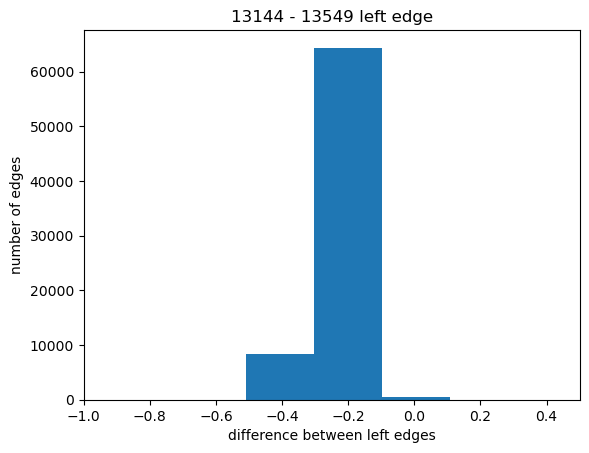

In [21]:
#make hist of the difference of the left edges 

diff = np.subtract(se13144, se13549)
plt.hist(diff)
plt.title("13144 - 13549 left edge")
plt.xlabel("difference between left edges")
plt.ylabel("number of edges")
plt.xlim(-1, 0.5)

On average, 13144 left edges are behind the left edges of 13549 by about 0.2. 

Text(0.5, 1.0, '13549 vs 13144 widths')

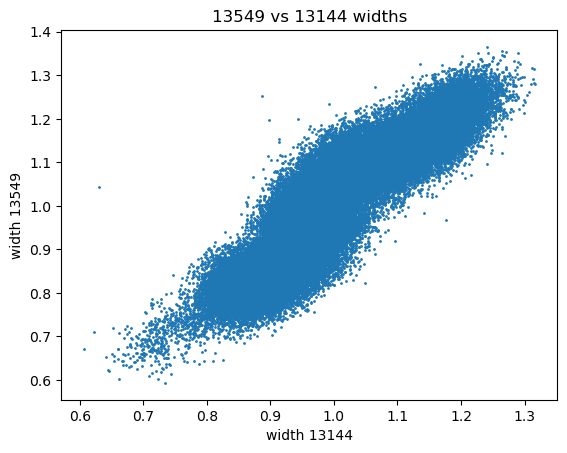

In [23]:
#scatter the widths of each bin from the two methods 

w13144 = d13144["widths"]
w13549 = d13549["widths"]

sw13549 = copy.deepcopy(w13549) 
sw13549 = sw13549[28:]

sw13144 = copy.deepcopy(w13144)
sw13144 = sw13144[:73282]

plt.scatter(sw13144, sw13549, s=1)
plt.xlabel("width 13144")
plt.ylabel("width 13549")
plt.title("13549 vs 13144 widths")

there appears to be a mostly linear (but some wiggle) relationship between the widths of the bins as made from the two datasets. 

Text(0.5, 1.0, 'width difference 13144-13549')

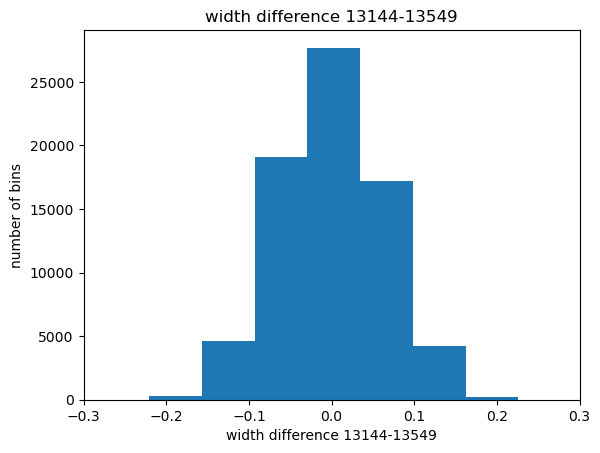

In [8]:
#hist of the difference of the bin widths

diffwidths = np.subtract(sw13144, sw13549)
plt.hist(diffwidths)
plt.xlim(-0.3, 0.3) #excludes 7 width differences
plt.xlabel("width difference 13144-13549")
plt.ylabel("number of bins")
plt.title("width difference 13144-13549")

It appears the widths made by the two methods are close, within 0.1 for most of the bin widths made by the two edges. Suggesting a stability in the binning method across the two datasets. 

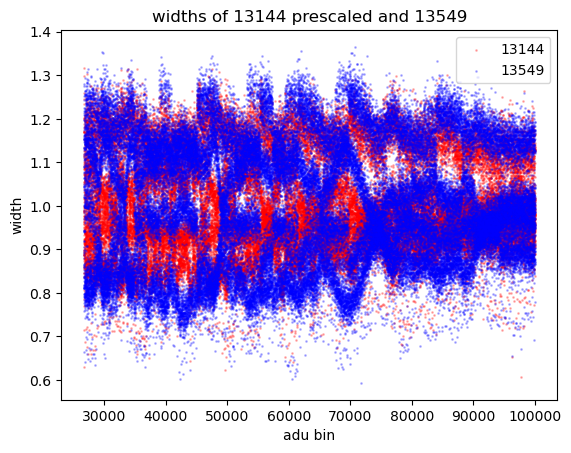

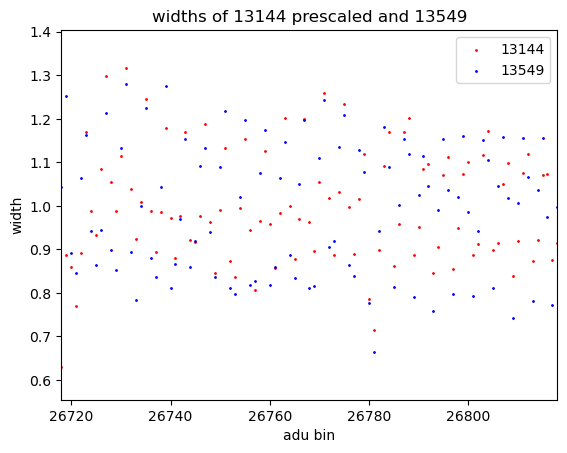

In [9]:
## Plot the widths themselves ontop of each other

plt.scatter(np.arange(26718, 26718+73282), sw13144, label='13144', alpha=0.25, color='red', s=1)
plt.scatter(np.arange(26718, 26718+73282), sw13549, label='13549', alpha=0.25, color='blue', s=1)
plt.legend()
plt.title("widths of 13144 prescaled and 13549")
plt.ylabel("width")
plt.xlabel("adu bin")
plt.show()

plt.scatter(np.arange(26718, 26718+73282), sw13144, label='13144', color='red', s=1)
plt.scatter(np.arange(26718, 26718+73282), sw13549, label='13549', color='blue', s=1)
plt.legend()
plt.xlim(26718, 26718+100)
plt.title("widths of 13144 prescaled and 13549")
plt.ylabel("width")
plt.xlabel("adu bin")
plt.show()

There is some deviation between the widths of the bins when plotted on top of each other. I have good reason to suspect that 13144 is the issue with the methods aligning, as from its own we see there is larger dnl for the early bins. 

Text(0.5, 1.0, 'left edges of adu bins by dataset')

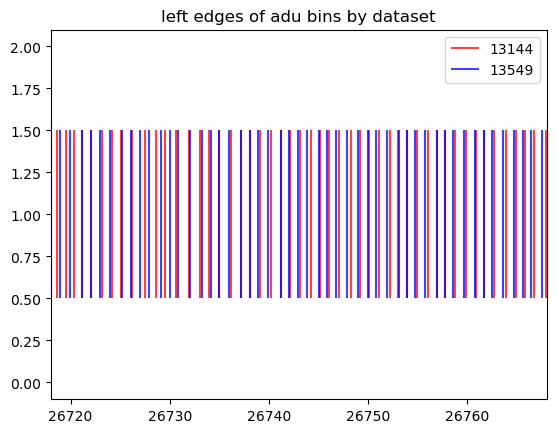

In [34]:
## make an eventplot of the edges 

plt.eventplot(se13144, label='13144', color='red', alpha=0.75)
plt.eventplot(se13549, label='13549', color='blue', alpha=0.75)
plt.xlim(26718, 26718+50)
plt.legend()
plt.title("left edges of adu bins by dataset")

This demonstrates the left edges of the two methods differs by some amount. It also shows there is some clumping of 13144 in this early region. I suspect this is due to way the prescale was done, in that it still is more skewed and oscilatory in the low region. I have good reason to suspect these will align more closely if I were to do a more robust prescale method to reduce this.

## Another comparison, starting the binning in a similar region, rather than two distinct

In [10]:
with open('13549_imageinfo.pkl', 'rb') as f:
    dict13549 = pkl.load(f) 
    
with open('13144_imageinfo.pkl', 'rb') as f:
    dict13144 = pkl.load(f) 

In [11]:
#arbitrarily choose to start binning at 26750 

e13549, r13549 = makeedges(dict13549["hist"], dict13549["bins"], dict13549["spline"], 1, 26750, 1e5, False)
w13549 = np.array(e13549[1:]) - np.array(e13549[:-1])

e13144, r13144 = makeedges(dict13144["hist"], dict13144["bins"], dict13144["spline"], 1, 26750, 1e5, False) #26718 
w13144 = np.array(e13144[1:]) - np.array(e13144[:-1])

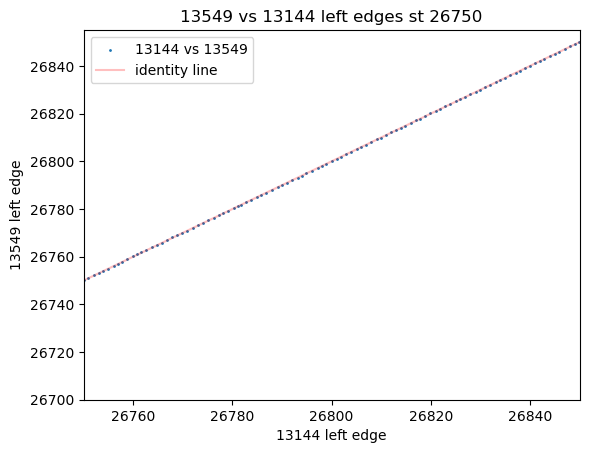

Text(0.5, 1.0, '13549 vs 13144 left edges st 26750')

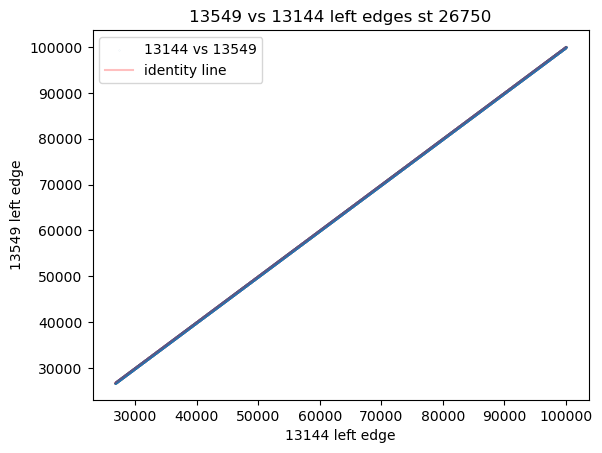

In [13]:
plt.scatter(e13144, e13549, s=1, label="13144 vs 13549")
plt.plot(np.arange(26750, 1e5), np.arange(26750, 1e5), label='identity line', alpha=0.25, color='red')
plt.legend()
plt.xlim(26750, 26750+100)
plt.ylim(2.67e4, 2.6855e4)
plt.xlabel("13144 left edge")
plt.ylabel("13549 left edge")
plt.title("13549 vs 13144 left edges st 26750")
plt.show()

plt.scatter(e13144, e13549, s=0.001, label="13144 vs 13549")
plt.plot(np.arange(26750, 1e5), np.arange(26750, 1e5), label='identity line', alpha=0.25, color='red')
plt.legend()
plt.xlabel("13144 left edge")
#plt.ylim(2.66e4, 10e4)
plt.ylabel("13549 left edge")
plt.title("13549 vs 13144 left edges st 26750")

The above demonstrates that the left edges of the two methods align with one another to a great extent as they follow the identity line. 

Text(0.5, 1.0, '13549 vs 13144 widths')

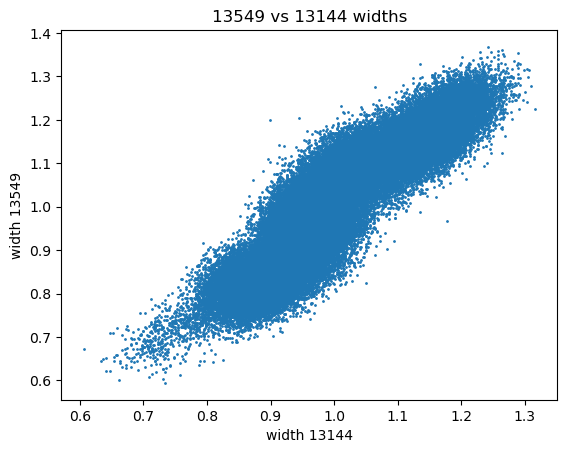

In [14]:
#scatter the widths of each bin from the two methods 
plt.scatter(w13144, w13549, s=1)
plt.xlabel("width 13144")
plt.ylabel("width 13549")
plt.title("13549 vs 13144 widths")

Widths made from the two methods demonstrates a roughly linear relationship, with the same wiggle from before. 

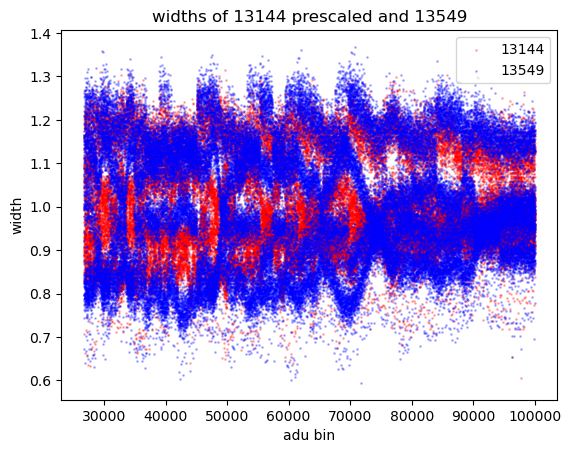

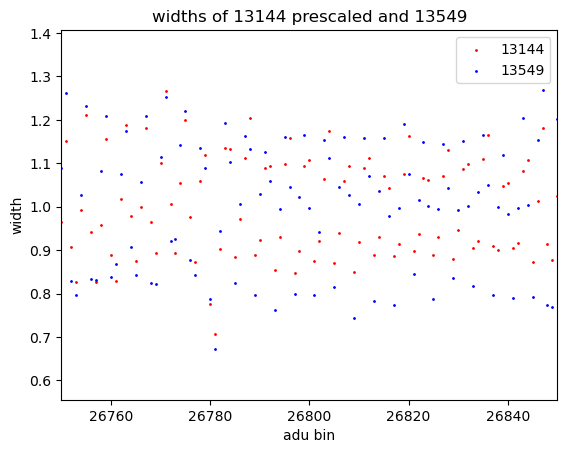

In [15]:
plt.scatter(np.arange(26750, 26750 + len(w13144)), w13144, label='13144', alpha=0.25, color='red', s=1)
plt.scatter(np.arange(26750, 26750 + len(w13549)), w13549, label='13549', alpha=0.25, color='blue', s=1)
plt.legend()
plt.title("widths of 13144 prescaled and 13549")
plt.ylabel("width")
plt.xlabel("adu bin")
plt.show()

plt.scatter(np.arange(26750, 26750 + len(w13144)), w13144, label='13144', color='red', s=1)
plt.scatter(np.arange(26750, 26750 + len(w13549)), w13549, label='13549', color='blue', s=1)
plt.legend()
plt.xlim(26750, 26750+100)
plt.title("widths of 13144 prescaled and 13549")
plt.ylabel("width")
plt.xlabel("adu bin")
plt.show()

We still observe the differing of the widths of the two bins when plotting on top of one another. 

Text(0.5, 1.0, 'width difference 13144-13549')

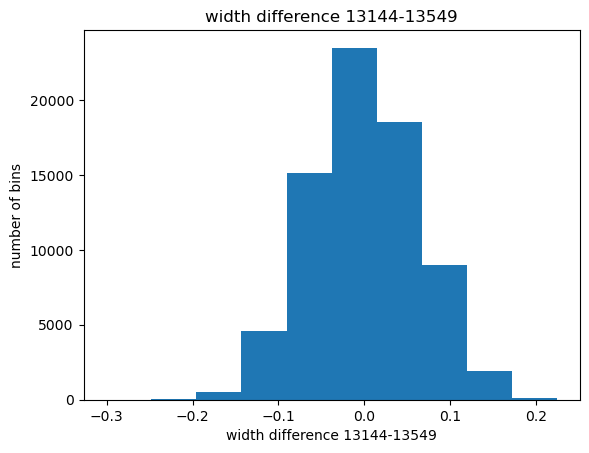

In [16]:
#hist of the difference of the bin widths

diffwidths = np.subtract(w13144, w13549)
plt.hist(diffwidths)
plt.xlabel("width difference 13144-13549")
plt.ylabel("number of bins")
plt.title("width difference 13144-13549")

It appears the widths made by the two methods are close, within 0.1 for most of the bin widths made by the two edges. Suggesting a stability in the binning method across the two datasets.

Text(0.5, 1.0, 'left edges of adu bins by dataset')

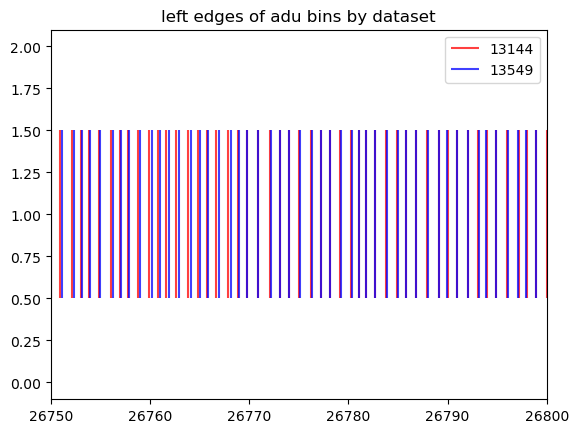

In [36]:
## make an eventplot of the edges 

plt.eventplot(e13144, label='13144', color='red', alpha=0.75)
plt.eventplot(e13549, label='13549', color='blue', alpha=0.75)
plt.xlim(26750, 26800)
plt.legend()
plt.title("left edges of adu bins by dataset")

This demonstrates the left edges of the two methods differs by some amount, although this looks better than the previous comparison. It also shows there is some clumping of 13144 in this early region. I suspect this is due to way the prescale was done, in that it still is more skewed and oscilatory in the low region. I have good reason to suspect these will align more closely if I were to do a more robust prescale method to reduce this.

Text(0.5, 1.0, 'left edge difference 13144-13549')

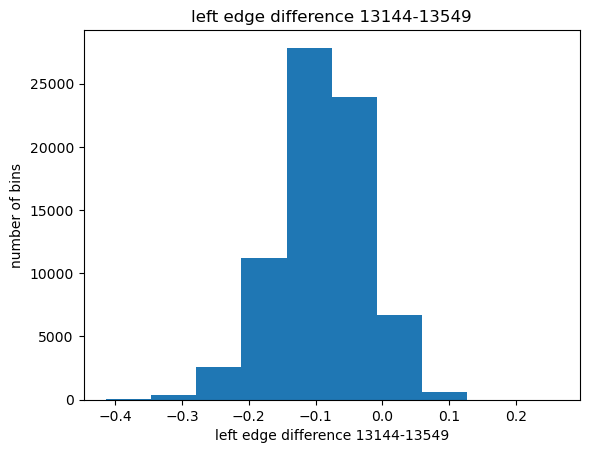

In [24]:
#make hist of the difference of the left edges 

diff = np.subtract(e13144, e13549)
plt.hist(diff)
plt.xlabel("left edge difference 13144-13549")
plt.ylabel("number of bins")
plt.title("left edge difference 13144-13549")

13144 left edges are on average to the left of 13549 left edges. 

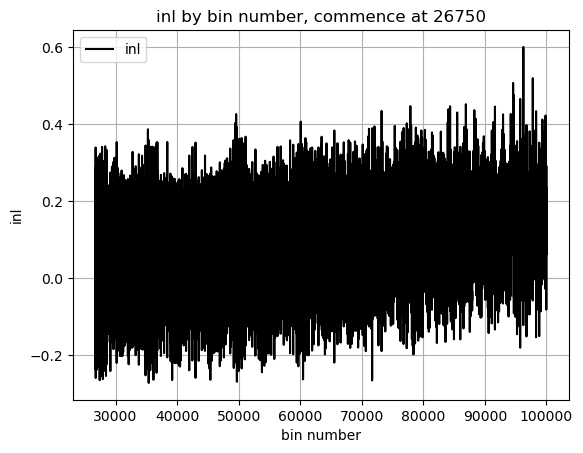

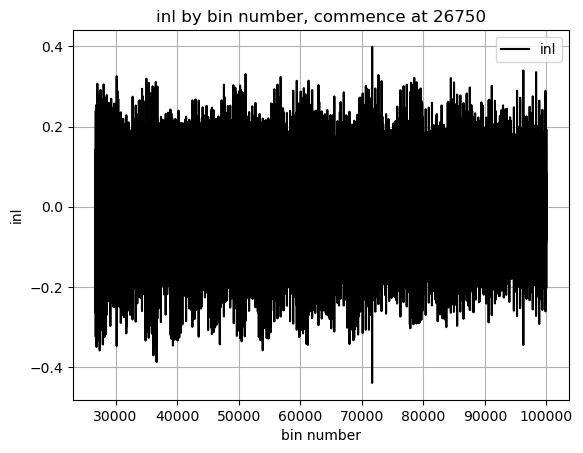

top 13144, bottom 13549


In [18]:
inl13144 = plotinl(e13144, 26750)
inl13549 = plotinl(e13549, 26750)
print("top 13144, bottom 13549")

the Inl contributions are seemingly consistent over the range of edges made by both datasets, with some slight upward behavior noticed for the prescaled method. 

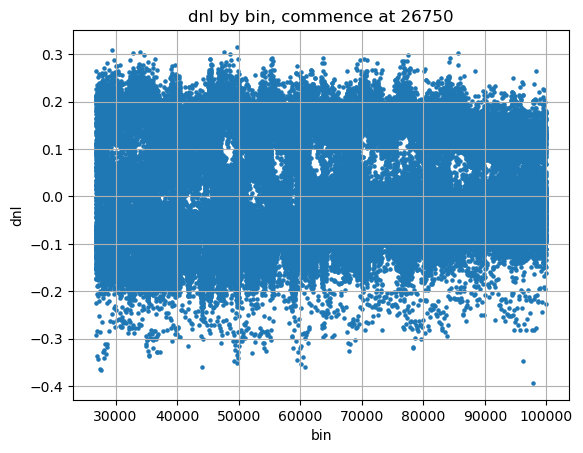

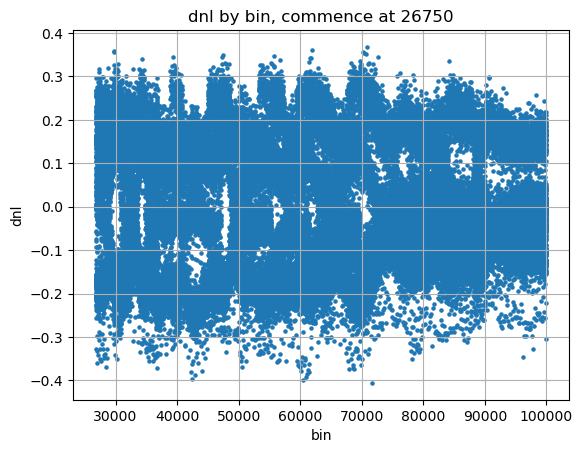

top 13144, bottom 13549


In [19]:
dnl13144 = plotdnl(e13144, 26750)
dnl13549 = plotdnl(e13549, 26750)
print("top 13144, bottom 13549")

no obvious deviations noted in the dnl between the two methods. 

## Downticks in 13549 (RAMP) 

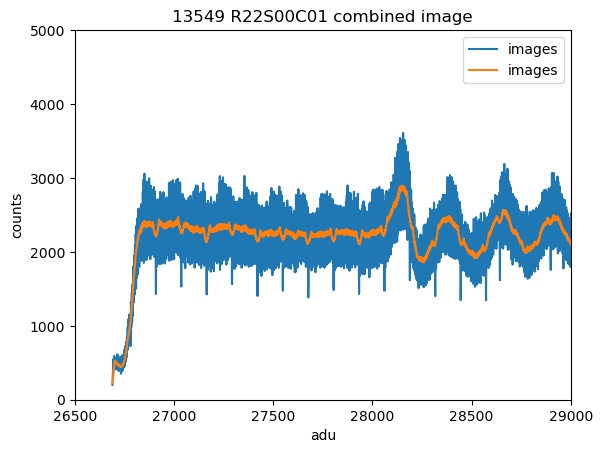

In [20]:
plt.plot(dict13549["bins"], dict13549["hist"], label='images')
plt.plot(dict13549["bins"], dict13549["filter"], label='images')
plt.xlabel("adu")
plt.ylabel("counts")
plt.title("13549 R22S00C01 combined image")
plt.xlim(2.65e4, 2.9e4)
plt.ylim(0, 5e3)
plt.legend()

Downticks still exist in the ramp run
Oscillations in the filter: artifact of the images themselves, since lower exposure times have narrower distributions, 
they are more peaked than others, showing up as these oscillations. When you zoom in on an early region, the ramp data still has this behavior, 
and the filter will pick up on this and show it. I could in principle adjust the filter to make it more smoothing, but have not done this